<a href="https://colab.research.google.com/github/SosaGabriel/DataScience/blob/main/PE_CredidCard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Credit Card Fraud Detection**
En este desfío de [Kaggle](https://https://www.kaggle.com/mlg-ulb/creditcardfraud) abordaremos el problema de fraudes con las tarjetas de crédito, situación que preocupa a las compañías financieras.
# **Contexto**
Es importante que las compañías de tarjetas de crédito puedan reconocer las transacciones fraudulentas de tarjetas de crédito para que no se cobre a los clientes por artículos que no compraron.

<p align=center>
<img src="https://www.consolidatedcredit.org/es/wp-content/uploads/2018/09/Fotolia_101260639_Subscription_Monthly_M-robo-de-identidad-768x537.jpg" width="60%"></p>

# **Contenido**
El conjunto de datos está desequilibrado y presenta transacciones que ocurrieron en dos días, donde tenemos *492 fraudes de 284.807 transacciones*.La clase positiva (fraudes) representa el  0,172% de **todas** las transacciones.
Contiene sólo variables de entrada numéricas que son el resultado de una transformación [PCA](https://https://www.cienciadedatos.net/documentos/35_principal_component_analysis) (Análisis de componentes principales): Principal Component Analysis es un método estadístico que permite simplificar la complejidad de espacios muestrales con muchas dimensiones a la vez que conserva su información.


Las características V1, V2,… V28 son los componentes principales obtenidos con PCA, las únicas características que no se han transformado con PCA son 'Tiempo' y 'Cantidad'. La característica 'Tiempo' contiene los segundos transcurridos entre cada transacción y la primera transacción en el conjunto de datos. La función 'Importe' es el Importe de la transacción, esta función se puede utilizar para el aprendizaje sensible al costo dependiente del ejemplo. **La característica 'Clase' es la variable de respuesta y toma el valor 1 en caso de fraude y 0 en caso contrario.**











In [ ]:
#@title
# suprimir los warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# instalar a biblioteca scikit-plot
!pip install -q scikit-plot

In [ ]:
# importamos paquetes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from imblearn.under_sampling import RandomUnderSampler

#estilo de los gráficos con Seaborn
sns.set_style('dark')


# Importar datos a Google Colaboratory

In [ ]:
from google.colab import drive 
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
#desde un archivo local
from google.colab import files
uploaded = files.upload()

Saving creditcard.csv to creditcard.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pwd

/content


In [ ]:
#Importamos los datos a un dataframes
df_cards= pd.read_csv('/content/creditcard.csv')

# **EDA**

Las primeras filas nos permite entender que con la transformación PCA dejó las features descaracterizada(anónimas) y con valores sólo numéricos.
Las columnas 'Times' y 'Amount' seran reservadas manteniendo su valor original
La variable objetivo está representada en la columna 'Class'.
* 0: Transacción normal
* 1: Transacción fraudulenta

In [ ]:
df_cards.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [ ]:
df_cards.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Verificando el resumen estadístico a continuación, utilizando el método describe (), podemos confirmar que las variables relacionadas con los componentes principales (transformación PCA) no tienen discrepancia aparente, al igual que la columna Tiempo.

En cuanto a la variable Amount(monto&, se observa que el valor promedio de las transacciones (considerando ambas clases 0,1) es 88.34, mediana igual a 22.00 y desviación estándar de 250.12.  
Al alcanzar el monto máximo de 25691.16, la mayoría de las transacciones financieras se componen principalmente de montos más pequeños, como se esperaba.

**Tenemos valores nulos?**

In [ ]:
df_cards.isnull().sum().max()

0

Como se indica en la descripción de los datos, las entradas por transacciones fraudulentas corresponden al 0,17% del total.

El gráfico de barras muestra cómo esta discrepancia se vuelve visible. En la práctica, esto interfiere con el rendimiento del modelo y será necesario equilibrar los datos antes de alimentar el modelo de clasificación final.

In [ ]:
#Corroboramos el %de fraudes
print(df_cards.Class.value_counts())
print("\nFraudes representan {:.4f}% del dataset.\n".format((df_cards[df_cards.Class == 1].shape[0] / df_cards.shape[0]) * 100))


0    284315
1       492
Name: Class, dtype: int64

Fraudes representan 0.1727% del dataset.



[]

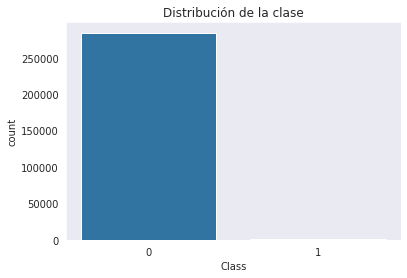

In [ ]:
#Gráfico de barras par las clases
fig, ax = plt.subplots()
sns.countplot('Class', data=df_cards, ax=ax)
ax.set_title('Distribución de la clase')
plt.plot()

La distribución de las 2 clases a lo largo del tiempo

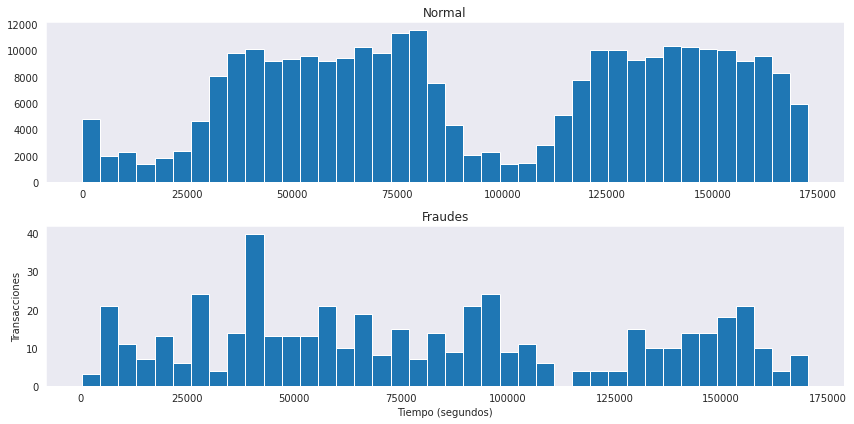

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6))

num_bins = 40

ax[0].hist(df_cards.Time[df_cards.Class == 0], bins=num_bins)
ax[0].set_title('Normal')

ax[1].hist(df_cards.Time[df_cards.Class == 1], bins=num_bins)
ax[1].set_title('Fraudes')

plt.xlabel('Tiempo (segundos)')
plt.ylabel('Transacciones')
plt.tight_layout()

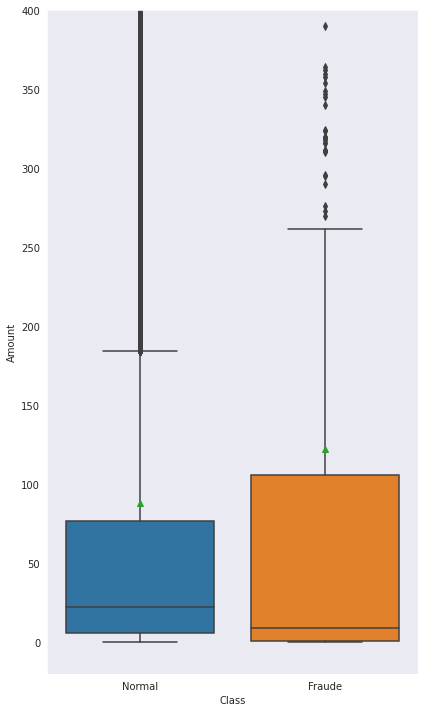

In [ ]:
fig, ax = plt.subplots(figsize=(6,10), sharex=True)

sns.boxplot(df_cards.Class, df_cards.Amount, showmeans=True, ax=ax)
plt.ylim((-20, 400))
plt.xticks([0, 1], ['Normal', 'Fraude'])

plt.tight_layout()

In [ ]:
df_cards[(df_cards.Class == 1) & (df_cards.Amount < 2000)]['Amount'].describe()

count     491.000000
mean      118.130550
std       240.439028
min         0.000000
25%         1.000000
50%         9.210000
75%       105.350000
max      1809.680000
Name: Amount, dtype: float64

La información estadística para df.Class == 1 muestra que su promedio exacto está en 118.13 y la mediana en 9.21.


El gráfico de densidad es muy útil para comparar las distribuciones de cada variable para cada clase y ver cuáles son más importantes para la detección de anomalías.
Lo que se busca en este tipo de visualización son distribuciones que se diferencian entre sí, permitiendo identificar más fácilmente el fraude. Ejemplos como las variables V3, V4, V10 y V11, ya que son muy diferentes.
Mientras que las variables V8, V13 y V15 son muy similares, presentando aproximadamente el mismo comportamiento.

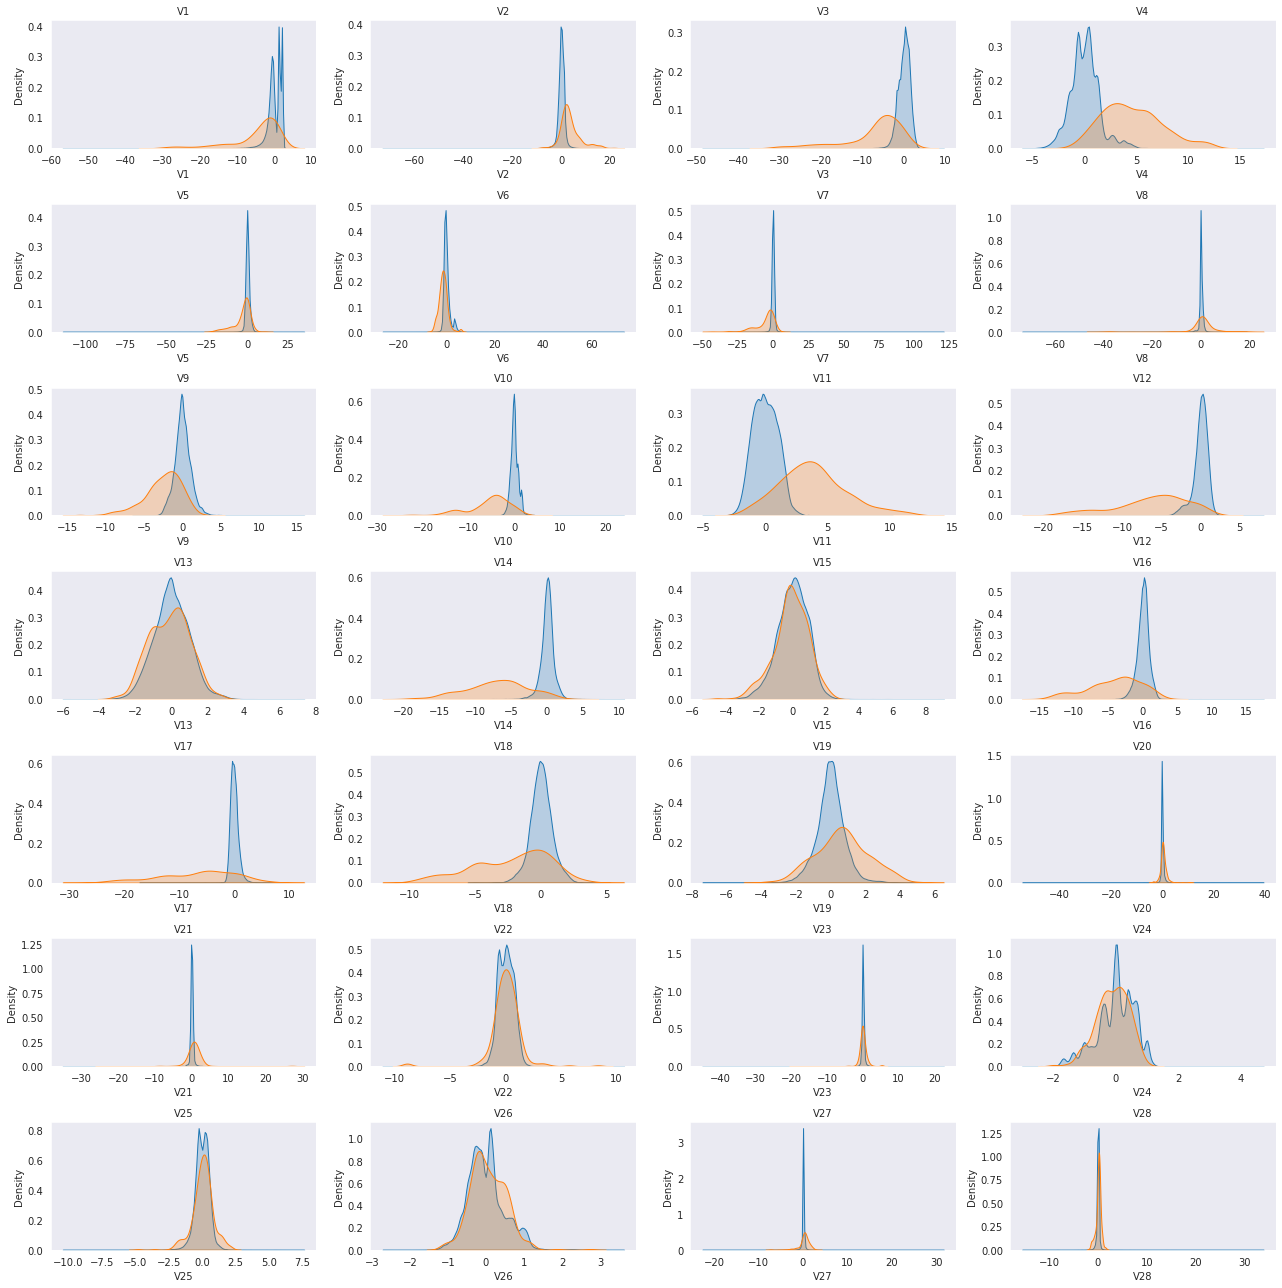

In [ ]:
column_names = df_cards.drop(['Class', 'Amount', 'Time'], axis=1).columns
num_plots = len(column_names)
df_class_0 = df_cards[df_cards.Class == 0]
df_class_1 = df_cards[df_cards.Class == 1]

fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(18,18))
fig.subplots_adjust(hspace=1, wspace=1)

idx = 0
for col in column_names:
    idx += 1
    plt.subplot(7, 4, idx)
    sns.kdeplot(df_class_0[col], label="Class 0", shade=True)
    sns.kdeplot(df_class_1[col], label="Class 1", shade=True)
    plt.title(col, fontsize=10)
plt.tight_layout()


**Observaciones:**
* 
El conjunto de datos está muy desequilibrado, ya que las transacciones fraudulentas representan solo el 0,17% del total de entradas.
* No hay valores faltantes o nulos en el marco de datos.
* 
Dado que el PCA es sensible a la escala de las variables, se asume que las columnas originales fueron estandarizada.
* Las columnas Time e Amount no están normalizadas.

**Preparando el conjunto de datos**
* Vamos a construir un modelo de regresión logistica
* 
Estandarizar las features Time y Amount, que están en otro orden de magnitud.
* Dividir los datos en train y test.
* 
Equilibre los datos para evitar un rendimiento deficiente para la clase 1 y el overfitting.

**Estandarizar las features Time y Amount**

In [ ]:
df_clean = df_cards.copy()

std_scaler = StandardScaler()
df_clean['std_amount'] = std_scaler.fit_transform(df_clean['Amount'].values.reshape(-1, 1))
df_clean['std_time'] = std_scaler.fit_transform(df_clean['Time'].values.reshape(-1, 1))

df_clean.drop(['Time', 'Amount'], axis=1, inplace=True)

# ver as primeiras entradas
df_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


***Dividir los datos en train y test***

Para garantizar que los conjuntos de entrenamiento y prueba tengan la misma cantidad de clases proporcionalmente, pasamos stratify=True.

In [ ]:
#Ejemplo: X_train, X_test, y_train, y_test = train_test_split
import numpy as np
from sklearn.model_selection import train_test_split
X, y = np.arange(10).reshape((5, 2)), range(5)
X

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [8, 9]])

In [ ]:
list(y)

[0, 1, 2, 3, 4]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train


array([[4, 5],
       [0, 1],
       [6, 7]])

In [ ]:
y_train

[2, 0, 3]

In [ ]:
X_test

array([[2, 3],
       [8, 9]])

In [ ]:
y_test

[1, 4]

In [ ]:
# separamos la variable en X e y 
X = df_clean.drop('Class', axis=1)
y = df_cards['Class']

# dividir el dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)

In [37]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,std_amount,std_time
192540,2.046574,-1.221689,-0.028360,-0.705190,-1.288485,0.557410,-1.693206,0.376810,0.199284,1.033573,0.249710,-0.073888,-0.355555,-0.072094,0.870819,-0.139819,-0.959766,2.471495,-1.025602,-0.556615,-0.100467,0.138224,0.332606,0.259935,-0.734462,0.578806,0.006074,-0.036977,-0.269709,0.735640
28125,1.027126,-0.938923,0.287170,-1.895006,-1.304449,-1.099637,-0.271368,-0.072425,2.008964,-1.471873,1.507081,1.441090,-0.738673,0.394957,0.798613,-0.921682,-0.029648,0.605773,1.368110,0.094690,0.133020,0.359601,-0.209601,0.578541,0.613352,-0.775743,0.053973,0.035821,0.126541,-1.262335
48125,0.947089,0.267137,-0.019474,2.411245,0.267506,-0.036528,0.460116,0.026288,-1.194734,0.841044,1.234889,0.182261,-1.016735,0.945255,-0.132119,0.288362,-0.395542,-0.324467,-0.981609,-0.037902,0.115249,0.037603,-0.166355,-0.002604,0.559736,0.073360,-0.051981,0.012122,0.063651,-1.080437
122772,1.314171,-1.421935,0.349231,-1.247845,-1.536010,-0.223229,-1.018588,-0.000538,-1.650515,1.438451,0.502732,-0.296307,-0.151736,-0.342476,-1.233609,-0.572917,0.584619,0.250668,0.568925,-0.192134,-0.326115,-0.636384,-0.056615,-0.032025,0.378664,-0.272920,0.018224,0.019742,0.034265,-0.381840
257969,1.769406,-0.416245,-0.708800,1.112970,0.664669,2.149538,-0.652580,0.693387,0.956435,0.010800,0.652305,1.393339,-0.475205,0.025295,-0.998473,-1.007688,0.428475,-1.632617,-0.481111,-0.330234,-0.413613,-0.889100,0.493631,-0.820520,-0.518159,-1.035406,0.095063,-0.047232,-0.273308,1.339687


In [38]:
X_train.shape

(213605, 30)

In [39]:
X_test.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,std_amount,std_time
32577,1.015790,-0.125529,1.174332,1.123338,-0.726474,0.372039,-0.659468,0.321057,0.234161,0.116427,1.436289,0.857339,-0.114354,0.235818,0.983188,0.594755,-0.670089,0.409212,-0.781697,-0.071777,0.203644,0.525905,-0.020512,0.014641,0.215963,-0.352551,0.066276,0.033364,-0.173316,-1.220409
118741,-0.437209,1.315829,0.849543,1.639569,0.099070,-0.668122,1.157573,-0.303545,-1.026936,-0.437071,0.077682,-0.242721,0.359460,-0.773664,1.672704,-0.433782,1.116208,0.496699,1.345583,0.194600,-0.030075,-0.029770,-0.285579,0.327097,0.506013,-0.082391,-0.051212,0.008679,-0.003317,-0.413090
171894,1.152851,-2.557103,0.444750,1.294268,-2.106910,1.431016,-1.457136,0.449034,1.070526,0.602039,-0.641458,1.172866,0.309558,-1.154004,-2.345828,-1.448524,-0.090503,2.107270,-0.697819,0.142719,0.032980,0.229038,-0.193125,-0.390218,-0.384705,-0.508916,0.085374,0.042510,1.269994,0.548604
76133,-0.353376,1.152752,1.304940,0.061918,0.087467,-0.978813,0.743729,-0.103853,-0.478088,-0.527562,-0.116848,0.215712,0.670925,-0.538423,0.833809,0.356306,-0.022699,-0.205717,-0.095228,0.155851,-0.255398,-0.644836,-0.015545,0.349179,-0.140808,0.069965,0.248280,0.099877,-0.335278,-0.808706
29627,1.202411,0.193871,-0.095970,0.982172,-0.163600,-0.512284,-0.056364,-0.079335,0.603291,-0.785533,-0.805914,0.099208,0.034108,-1.613644,-0.209417,0.245686,0.948117,0.186570,0.164031,-0.015250,-0.201385,-0.367963,-0.173631,-0.171400,0.611550,0.440182,-0.001700,0.041218,-0.235046,-1.247890


In [40]:
X_test.shape

(71202, 30)

In [41]:
y_train.head()

192540    0
28125     0
48125     0
122772    0
257969    0
Name: Class, dtype: int64

In [42]:
y_test.head

<bound method NDFrame.head of 32577     0
118741    0
171894    0
76133     0
29627     0
         ..
172630    0
45498     0
77158     0
12568     0
137854    0
Name: Class, Length: 71202, dtype: int64>

In [43]:
y_train.shape,y_test.shape

((213605,), (71202,))

Con la biblioteca **imblearn** es posible aplicar fácilmente técnicas de equilibrio de datos. En este caso, la opción en este proyecto fue utilizar Under-sampling (submuestras), preservando la clase minoritaria.

Es fácil ver que ya no existe esa discrepancia inicial (gráfico de barras al comienzo de este notebook).

1    369
0    369
dtype: int64


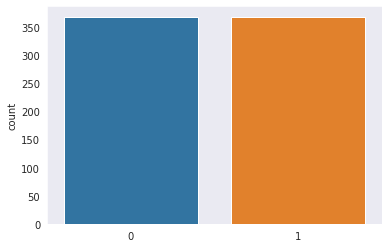

In [44]:
# Técnica under-sampling
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X_train, y_train)

# Equilibrio de las clases
print(pd.Series(y_rus).value_counts())

# Graficar nueva distribución de las clases
sns.countplot(y_rus);

Con los datos balanceados, podemos ver la matriz de correlación e identificar qué variables están más fuertemente relacionadas con las demás.


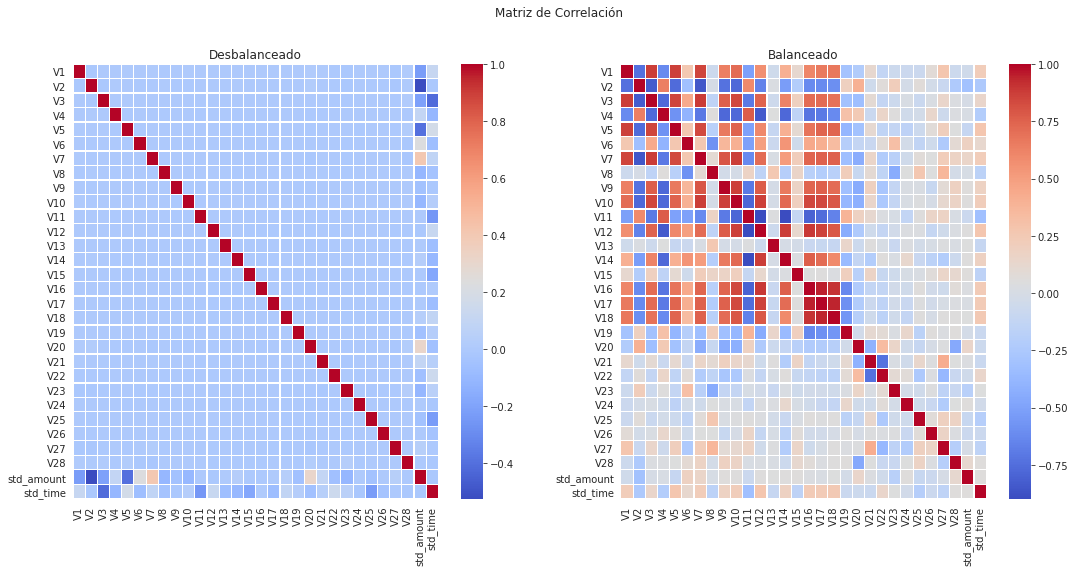

In [45]:
# Graficar matriz de correlacion
corr = X_train.corr()
corr_rus = pd.DataFrame(X_rus).corr()


fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (18,8))
fig.suptitle('Matriz de Correlación')

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax[0])
ax[0].set_title('Desbalanceado')

sns.heatmap(corr_rus, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax[1])
ax[1].set_title('Balanceado')

plt.show()

## Modelo de Machine Learning

In [46]:
# instanciar y entrenar un modelo de Regresión Logistica
np.random.seed(2)
model = LogisticRegression()
model.fit(X_rus, y_rus)

# hacer predicciones sobre los datos de prueba
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)


Con el modelo entrenado y las predicciones realizadas, se procede a evaluar el rendimiento.

En este tipo de problemas, originalmente desequilibrados, la precisión no es una métrica adecuada, se puede presentar el caso: tener una precisión del 99,88% y detectar menos del 60% de fraude.

La matriz de confusión para ver la tasa de aciertos de transacciones fraudulentas, o por la columna de recuperación del Informe de clasificación.

Informe de clasificación:
               precision    recall  f1-score   support

           0     0.9998    0.9682    0.9837     71079
           1     0.0472    0.9106    0.0897       123

    accuracy                         0.9681     71202
   macro avg     0.5235    0.9394    0.5367     71202
weighted avg     0.9982    0.9681    0.9822     71202

Presición: 0.9681

AUC: 0.9394



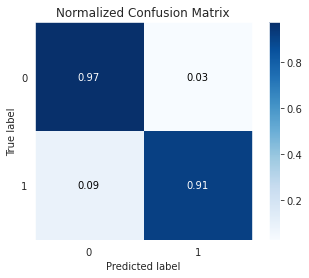

In [47]:
# Matriz de confusión
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

# Informe de clasificación
print("Informe de clasificación:\n", classification_report(y_test, y_pred, digits=4))

# Presición del modelo
print("Presición: {:.4f}\n".format(accuracy_score(y_test, y_pred)))

# Area sob de la curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))


Como puede ver, este no es un problema trivial. A pesar de que los datos están bien tratados y limpios, sin valores perdidos ni variables categóricas, el desequilibrio y la Transformación del PCA requirieron un trabajo considerable.

Evidentemente, a pesar del buen resultado final, hay margen para testear el rendimiento con otros algoritmos de clasificación, además de optimizar sus parámetros.